<a href="https://colab.research.google.com/github/giakomorssi/Deloitte_Project/blob/main/02_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error

import pandas as pd

# Change Colab runtime to GPU
import os
os.environ['COLAB_TPU_ADDR'] = ''
os.environ['COLAB_GPU_ALLOC'] = '1'
os.environ['COLAB_GPU'] = '1'
print("Runtime switched to GPU")

import tensorflow as tf

if not tf.test.gpu_device_name():
    print('GPU device not found')
else:
    print('GPU device found:', tf.test.gpu_device_name())

# This code sets the runtime to use the GPU if available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

pd.set_option('display.max_columns', None)

!pip install -q category_encoders

Mounted at /content/drive
Runtime switched to GPU
GPU device found: /device:GPU:0
Default GPU Device: /device:GPU:0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 8.1 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset.csv', encoding = 'latin-1')

# Old System

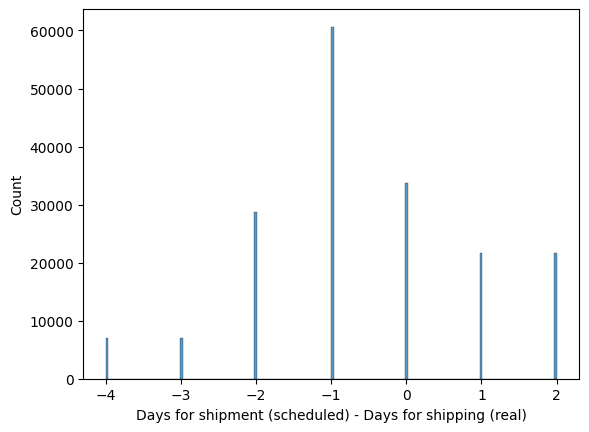

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(df['Days for shipment (scheduled)'] - df['Days for shipping (real)'])
plt.xlabel('Days for shipment (scheduled) - Days for shipping (real)')
plt.ylabel('Count')
plt.show()

# Cleaning the Data

In [3]:
# Remove Na and Empty Columns

df.drop(['Delivery Status', 'Order Status', 'Product Description', 'Order Zipcode', 'Order Profit Per Order', 'Customer Email', 
         'Customer Password', 'Customer Country', 'Customer Id', 'Customer Fname', 'Customer Lname', 'Customer Street', 'Order Country', 
         'Product Card Id', 'Product Category Id', 'Product Image', 'Customer State', 'Category Id', 'Department Id', 'Order Customer Id', 
         'Order Id', 'Order Item Cardprod Id', 'Order Item Id', 'Product Name', 'Days for shipment (scheduled)'], axis = 1, inplace = True) 
df.drop('Late_delivery_risk', axis = 1, inplace = True)
df.dropna(inplace = True) #remove 1 missing value

In [4]:
from datetime import datetime

df['order date'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date'] = pd.to_datetime(df['shipping date (DateOrders)'])

df['order date'] = df['order date'].apply(lambda x: x.timestamp())
df['shipping date'] = df['shipping date'].apply(lambda x: x.timestamp())

df.drop(['order date (DateOrders)', 'shipping date (DateOrders)'], axis = 1, inplace = True)

In [5]:
df.to_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset_prediction.csv', index = False)

# Encoding

### Label Encoding

In [61]:
df = pd.read_csv('/content/drive/MyDrive/University/Deloitte/SupplyChainDataset_prediction.csv')

In [62]:
from sklearn.model_selection import train_test_split

X = df.drop(['Days for shipping (real)'], axis = 1)
y = df['Days for shipping (real)']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [64]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder

# initialize the encoder
enc = LeaveOneOutEncoder(cols=['Customer City', 'Order City', 'Order State', 'Order Region'])

# fit and transform the entire dataset
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

In [65]:
from sklearn.preprocessing import OneHotEncoder

# Select columns for one-hot encoding
one_hot_cols = [0, 3, 5, 7, 10]
#one_hot_cols = [0, 4, 6, 8, 11] #if we keep Late_delivery_risk

# Type, Department Name, Category Name, Market, Order Status, Customer Segment

# Fit one-hot encoder to training data
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

# Apply one-hot encoder to training and test data
X_train_one_hot = one_hot_encoder.fit_transform(X_train.iloc[:, one_hot_cols])
X_test_one_hot = one_hot_encoder.transform(X_test.iloc[:, one_hot_cols])

# Remove original columns from training and test data
X_train = X_train.drop(X_train.columns[one_hot_cols], axis=1)
X_test = X_test.drop(X_test.columns[one_hot_cols], axis=1)

# Concatenate one-hot encoded columns with remaining data
X_train = pd.concat([pd.DataFrame(X_train_one_hot.toarray()), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test_one_hot.toarray()), X_test.reset_index(drop=True)], axis=1)

In [66]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Shipping Mode
custom_order = ['Same Day', 'First Class', 'Second Class', 'Standard Class']
le.fit(custom_order)
X_train['Shipping Mode'] = le.fit_transform(X_train['Shipping Mode'])
X_test['Shipping Mode'] = le.transform(X_test['Shipping Mode'])

## Scale the Data

In [67]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train.iloc[:, 73:] = scaler.fit_transform(X_train.iloc[:, 73:])
X_test.iloc[:, 73:] = scaler.transform(X_test.iloc[:, 73:])

<ipython-input-67-9ae7bc4a0d38>:5: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-67-9ae7bc4a0d38>:6: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [68]:
import pandas as pd
import numpy as np
import pickle

# Split the dataset into features and target
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_train = np.ravel(y_train)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [69]:
X_train.shape

(144412, 94)

# Prediction

## Choosing the Model

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge

model = VotingRegressor([('brr', BayesianRidge()), ('ridge', Ridge())], weights=[2, 1])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/voting_no_late.pkl', 'wb') as f:
  pickle.dump(model, f)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))

rMSE 0.22078022006372397


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

model = StackingRegressor(estimators=[('brr', BayesianRidge()), ('ridge', Ridge())], final_estimator=DecisionTreeRegressor())

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

with open('/content/drive/MyDrive/University/Deloitte/models_lr/stacking_no_late.pkl', 'wb') as f:
  pickle.dump(model, f)

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))

rMSE 0.16650963870854307


## try

In [70]:
import pickle

with open('/content/drive/MyDrive/University/Deloitte/models_lr/stacking_no_late.pkl', 'rb') as f:
  model = pickle.load(f)

y_pred = model.predict(X_test)

residuals = y_test - y_pred

print('rMSE', mean_squared_error(y_test, y_pred, squared=False))

rMSE 0.16450140879138286


In [ ]:
import numpy as np
import pandas as pd

# Initialize a dictionary to store the squared errors and average predictions for each class
mse_dict = {label: {'errors': [], 'preds': []} for label in np.unique(y_test)}

# Calculate the squared error and average prediction for each instance and add them to the corresponding class lists
for true_label, pred_label, error in zip(y_test, y_pred, (y_test - y_pred) ** 2):
    mse_dict[true_label]['errors'].append(error)
    mse_dict[true_label]['preds'].append(pred_label)

# Calculate the mean squared error and average prediction for each class and add the results to the table_data list
table_header = ['Class', 'Instances', 'RMSE', 'Average Predicted Value']
table_data = []
for label in mse_dict:
    instances = len(mse_dict[label]['errors'])
    if instances > 0:
        mse = np.mean(mse_dict[label]['errors'])
        rmse = np.sqrt(mse)
        avg_pred = np.mean(mse_dict[label]['preds'])
        table_data.append([label, instances, f'{rmse:.4f}', f'{avg_pred:.4f}'])
    else:
        table_data.append([label, 'no instances', 'N/A', 'N/A'])

# Print the table
print(pd.DataFrame(table_data, columns=table_header))

   Class  Instances    RMSE Average Predicted Value
0      0        998  0.6678                  0.4459
1      1        943  0.7433                  0.4475
2      2      11248  0.0000                  2.0000
3      3       5801  0.0000                  3.0000
4      4       5706  0.0000                  4.0000
5      5       5595  0.0000                  5.0000
6      6       5813  0.0000                  6.0000


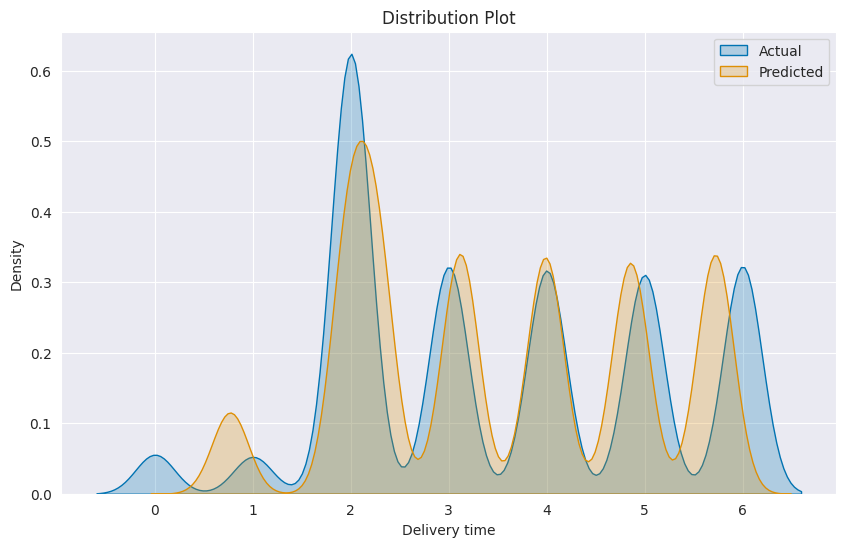

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_palette('colorblind')
sns.set_style('darkgrid')
sns.kdeplot(y_test.ravel(), label='Actual', fill=True)
sns.kdeplot(y_pred.ravel(), label='Predicted', fill=True)
plt.xlabel('Delivery time')
plt.ylabel('Density')
plt.title('Distribution Plot')
plt.legend()
plt.show()

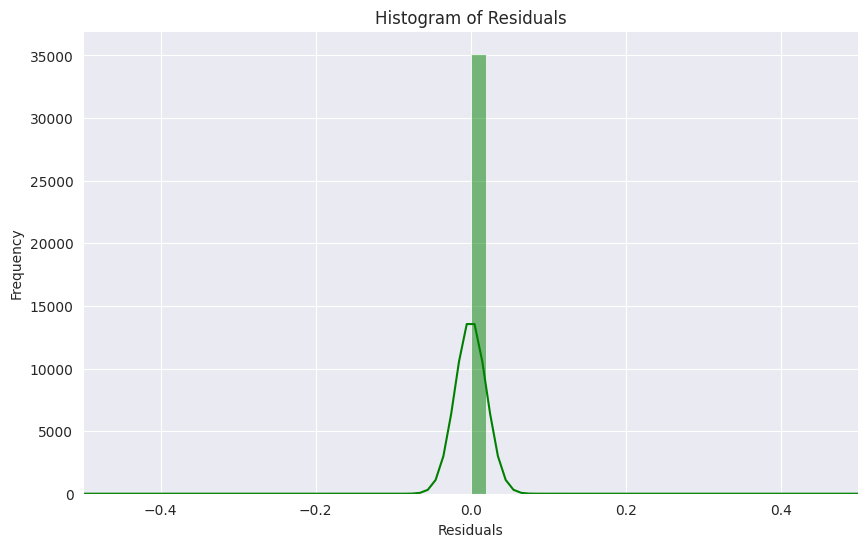

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(residuals, bins=100, color='green', kde=True, ax=ax)
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Residuals')
ax.set_xlim((-0.5, 0.5))
sns.despine()
plt.show()

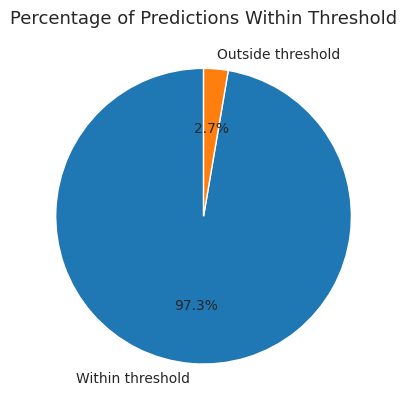

In [ ]:
within_threshold = (np.abs(y_pred.ravel() - y_test.ravel()) < 0.3).mean() #0.1 = 2.4 hours
outside_threshold = 1 - within_threshold
fig, ax = plt.subplots()
labels = ['Within threshold', 'Outside threshold']
sizes = [within_threshold, outside_threshold]
colors = ['#1f77b4', '#ff7f0e']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Predictions Within Threshold', fontsize=13)
plt.show()

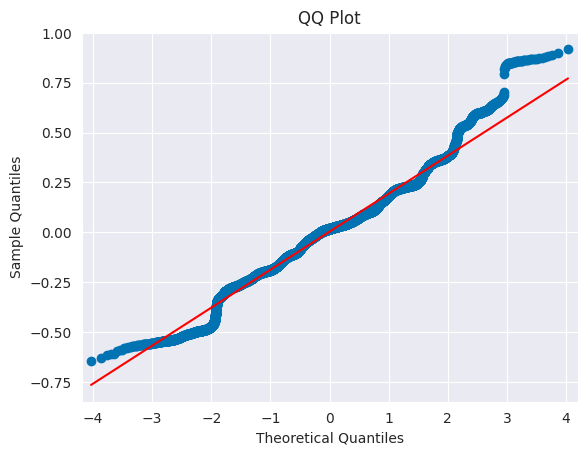

In [ ]:
import statsmodels.api as sm

fig, ax = plt.subplots()
sm.qqplot(residuals, line='s', ax=ax)
ax.set_title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

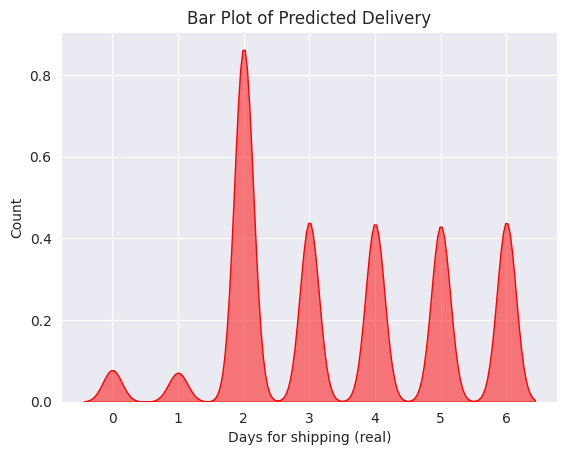

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.kdeplot(y, color='red', label='Predicted', legend=True, fill=True, alpha = 0.5)

plt.xlabel("Days for shipping (real)")
plt.ylabel("Count")
plt.title("Bar Plot of Predicted Delivery")
plt.show()

In [82]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

temp = df["Days for shipping (real)"].value_counts()
df1 = pd.DataFrame({'Real': temp.index, 'values': temp.values})
# Define a list of colors for the bars
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']

traces = []

for i, category in enumerate(df1['Real']):
    if category == 0:
        name = "0"
    elif category == 1:
        name = "1"
    elif category == 2:
        name = "2"
    elif category == 3:
        name = "3"
    elif category == 4:
        name = "4"
    elif category == 5:
        name = "5"
    else:
        name = "6"
    trace = go.Bar(
        x=[name], y=[df1.loc[i, 'values']],
        name=name,
        marker=dict(color=colors[i]),
        text=[df1.loc[i, 'values']],
        legendgroup="group"
    )
    traces.append(trace)

layout = dict(title='Credit Card Fraud Class - data unbalance',
              xaxis=dict(title='Class', showticklabels=True), 
              yaxis=dict(title='Number of transactions'),
              hovermode='closest', width=600,
              showlegend=True
             )
fig = go.Figure(data=traces, layout=layout)
iplot(fig, filename='class')